In [1]:
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit
from iminuit.cost import LeastSquares
from IPython.display import Latex

<h1> Data

In [2]:
def func(x,a,b):
    return a*x**2+b*x

In [3]:
def genData(xMin,xMax,theta:list,sigma,N:int):

    x = np.linspace(xMin,xMax,N)
    y = np.empty(N)

    for i in range(N):
        
        y[i] = func(x[i],theta[0],theta[1]) + np.random.normal(0,sigma)

    return x,y

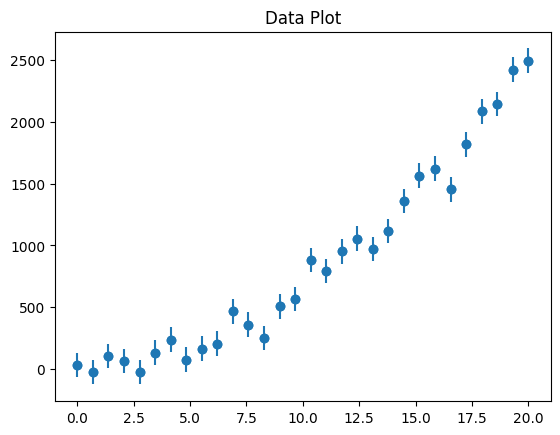

In [27]:
xmin,xmax = 0 , 20
N     = 30
sigma = 100

a,b = 6,2

data = genData(xmin,xmax,(a,b),sigma,N)

sigmay = [sigma for i in range(N)]

plt.title("Data Plot")
plt.scatter(data[0],data[1])
plt.errorbar(data[0],data[1], xerr=0,yerr=sigmay, linestyle = 'None', marker='o')
plt.show()

<h4>Fitting the data

In [28]:
dataFit = LeastSquares(data[0],data[1],sigmay,func)

my_minuit = Minuit(dataFit,a=0.,b=0,)
my_minuit.migrad()
my_minuit.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 28.2 (χ²/ndof = 1.0)       │              Nfcn = 41               │
│ EDM = 1.57e-21 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │    6.1    │    0.4    │            │            │         │         │       │
│ 1 │ b    │     4     │     6     │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────┐
│   │     a     b │
├───┼─────────────┤
│ a │ 0.159 -2.42 │
│ b │ -2.42  39.4 │
└───┴─────────────┘

In [29]:
# for par, val, err in zip (my_minuit.parameters, my_minuit.values, my_minuit.errors) :
#     print(f'{par} = {val:.3f} +/- {err:.3f}')

Latex(f"$$a = {a} \\newline b = {b} \\newline a = {my_minuit.values[0]} \pm {my_minuit.errors[0]} \\newline b = {my_minuit.values[1]} \pm {my_minuit.errors[1]}$$")

<IPython.core.display.Latex object>

In [60]:
def Q_2(sample):
    m = np.average(sample)
    s = np.std(sample)
    sum = 0
    

    for i in sample:
        sum += ((i-m)/s)**2
    return sum

In [63]:
Q_squared = my_minuit.fval
N_dof = my_minuit.ndof
print("Q squared: ",Q_squared)

Q squared:  28.197575352878445
